In [1]:
import random
import time
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
from run import utils

## 100x100 Convex Quadratic

In [2]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# init
num_var = 100     # number of variables
num_ineq = 100    # number of constraints
num_data = 10000  # number of data
test_size = 1000  # number of test size
val_size = 1000   # number of validation size
train_size = num_data - test_size - val_size


# data sample from uniform distribution
b_samples = torch.from_numpy(np.random.uniform(-1, 1, size=(num_data, num_ineq))).float()
data = {"b":b_samples}
# data split
from src.utlis import data_split
data_train, data_test, data_dev = data_split(data, test_size=test_size, val_size=val_size)

# torch dataloaders
from torch.utils.data import DataLoader
batch_size = 64
loader_train = DataLoader(data_train, batch_size, num_workers=0, collate_fn=data_train.collate_fn, shuffle=True)
loader_test = DataLoader(data_test, batch_size, num_workers=0, collate_fn=data_test.collate_fn, shuffle=False)
loader_dev = DataLoader(data_dev, batch_size, num_workers=0, collate_fn=data_dev.collate_fn, shuffle=False)

# init model
from src.problem import msQuadratic
model = msQuadratic(num_var, num_ineq, timelimit=600)

In [ ]:
# get b
b = data_test.datadict["b"][0].cpu().numpy()

### Rounding Classification

In [4]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [5]:
# hyperparameters
penalty_weight = 100  # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 256           # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

# set problem
import neuromancer as nm
from src.problem import nmQuadratic
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_ineq, outsize=num_var, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["b"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=num_ineq+num_var, hidden_dims=[hsize]*hlayers_rnd, output_dim=num_var)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["b"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind={"x":range(num_var)}, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmQuadratic(["b", "x_rnd"], num_var, num_ineq, penalty_weight)

from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 3603.61
Epoch 0, Iters 125, Training Loss: 251.62, Validation Loss: 4.14
Epoch 1, Iters 250, Training Loss: 0.69, Validation Loss: -2.77
Epoch 2, Iters 375, Training Loss: -3.31, Validation Loss: -5.74
Epoch 3, Iters 500, Training Loss: -5.01, Validation Loss: -7.80
Epoch 4, Iters 625, Training Loss: -5.68, Validation Loss: -6.14
Epoch 5, Iters 750, Training Loss: -6.36, Validation Loss: -8.47
Epoch 6, Iters 875, Training Loss: -7.01, Validation Loss: -8.45
Epoch 7, Iters 1000, Training Loss: -7.43, Validation Loss: -8.88
Epoch 8, Iters 1125, Training Loss: -7.96, Validation Loss: -8.79
Epoch 9, Iters 1250, Training Loss: -8.23, Validation Loss: -9.00
Epoch 10, Iters 1375, Training Loss: -8.38, Validation Loss: -8.97
Epoch 11, Iters 1500, Training Loss: -8.79, Validation Loss: -9.72
Epoch 12, Iters 1625, Training Loss: -8.99, Validation Loss: -9.65
Epoch 13, Iters 1750, Training Loss: -9.37, Validation Loss: -10.57
Epoch 14, Iters 1875, Training Loss:

In [6]:
# data point as tensor
datapoints = {"b": torch.unsqueeze(b, 0).to("cuda"), "name": "test"}
# infer
components.eval()
tick = time.time()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
tock = time.time()
elapsed = tock - tick
# assign params
model.set_param_val({"b":b.cpu().numpy()})
# assign vars
x = datapoints["x_rnd"]
for i in range(num_var):
    model.vars["x"][i].value = x[0,i].item()
# get solutions
xval, objval = model.get_val()
viol = np.mean(model.cal_violation())
print(f"Obj: {objval:.4f} with {viol:.4f} violation in {elapsed:.4f} sec.")

Obj: -13.5470 with 0.0000 violation in 0.0037 sec.


### Learnable Threshold

In [7]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
# hyperparameters
penalty_weight = 100  # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 256           # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

# set problem
import neuromancer as nm
from src.problem import nmQuadratic
from src.func.layer import netFC
from src.func import roundThresholdModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_ineq, outsize=num_var, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["b"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=num_ineq+num_var, hidden_dims=[hsize]*hlayers_rnd, output_dim=num_var)
rnd = roundThresholdModel(layers=layers_rnd, param_keys=["b"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind=model.int_ind, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmQuadratic(["b", "x_rnd"], num_var, num_ineq, penalty_weight)

from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 2485.01
Epoch 0, Iters 125, Training Loss: 251.90, Validation Loss: 3.37
Epoch 1, Iters 250, Training Loss: -4.55, Validation Loss: -6.44
Epoch 2, Iters 375, Training Loss: -7.11, Validation Loss: -8.40
Epoch 3, Iters 500, Training Loss: -7.86, Validation Loss: -9.23
Epoch 4, Iters 625, Training Loss: -8.52, Validation Loss: -9.12
Epoch 5, Iters 750, Training Loss: -9.32, Validation Loss: -10.19
Epoch 6, Iters 875, Training Loss: -9.05, Validation Loss: -9.11
Epoch 7, Iters 1000, Training Loss: -9.40, Validation Loss: -9.75
Epoch 8, Iters 1125, Training Loss: -9.41, Validation Loss: -8.82
Epoch 9, Iters 1250, Training Loss: -9.85, Validation Loss: -10.60
Epoch 10, Iters 1375, Training Loss: -10.27, Validation Loss: -11.07
Epoch 11, Iters 1500, Training Loss: -10.46, Validation Loss: -11.12
Epoch 12, Iters 1625, Training Loss: -10.23, Validation Loss: -11.44
Epoch 13, Iters 1750, Training Loss: -10.50, Validation Loss: -9.58
Epoch 14, Iters 1875, Train

In [9]:
# data point as tensor
datapoints = {"b": torch.unsqueeze(b, 0).to("cuda"), "name": "test"}
# infer
components.eval()
tick = time.time()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
tock = time.time()
elapsed = tock - tick
# assign params
model.set_param_val({"b":b.cpu().numpy()})
# assign vars
x = datapoints["x_rnd"]
for i in range(num_var):
    model.vars["x"][i].value = x[0,i].item()
# get solutions
xval, objval = model.get_val()
viol = np.mean(model.cal_violation())
print(f"Obj: {objval:.4f} with {viol:.4f} violation in {elapsed:.4f} sec.")

Obj: -13.6711 with 0.0000 violation in 0.0040 sec.


### Exact Solver

In [10]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [11]:
# set n
model.set_param_val({"b":b})
# solve
xval, objval = model.solve("gurobi", tee=True, keepfiles=True)

Solver script file: 'C:\Users\lucas\AppData\Local\Temp\tmpngu7okky.gurobi.script'
Solver log file: 'C:\Users\lucas\AppData\Local\Temp\tmp2uxkdxe6.gurobi.log'
Solver solution file: 'C:\Users\lucas\AppData\Local\Temp\tmpcwvkhpgt.gurobi.txt'
Solver problem files: ('C:\\Users\\lucas\\AppData\\Local\\Temp\\tmpn3su24zw.pyomo.lp',)
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-25
Read LP format model from file C:\Users\lucas\AppData\Local\Temp\tmpn3su24zw.pyomo.lp
Reading time = 0.01 seconds
x1: 100 rows, 100 columns, 10000 nonzeros
Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 5800HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 100 rows, 100 columns and 10000 nonzeros
Model fingerprint: 0x022e99b5
Model has 100 quadratic objective terms
Variable 

### Plot

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
cset =  tc.tol_cset("medium-contrast")
from brokenaxes import brokenaxes

In [2]:
def plotObj(times, objs):
    # prepare data for step-like plot
    time_steps = []
    obj_steps = []
    for i in range(len(times)):
        if i > 0:
            time_steps.append(times[i])  # add the current time
            obj_steps.append(objs[i - 1])  # previous obj value
        time_steps.append(times[i])  # add the current time
        obj_steps.append(objs[i])  # current obj value
    # create subplots for a broken y-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4), gridspec_kw={"height_ratios":[2, 8]}) 
    ax1.step(time_steps, np.array(obj_steps)/1e17, where='post', linewidth=4, color=cset.light_yellow)
    ax1.set_ylim(objs[0]/1e17 - 0.5, objs[0]/1e17 + 0.5)
    ax1.spines["bottom"].set_visible(False)
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x * 1e17:.1e}"))
    ax1.tick_params(labelbottom=False)  # hide x-axis labels for the top plot
    # plot for the bottom (detailed range)
    ax2.step(time_steps, obj_steps, where="post", linewidth=4, color=cset.light_yellow, label="EX (Gurobi)")
    ax2.scatter(0.0037, -13.5470+0.3, s=200, color=cset.light_blue, label="RC", zorder=8)
    ax2.scatter(0.0040, -13.6711, s=200, color=cset.light_red, label="LT", zorder=8)
    ax2.set_ylim(-22, 0)
    ax2.spines['top'].set_visible(False)
    # diagonal lines to indicate the break
    d = 0.015  # Size of diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    plt.tight_layout()
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # style
    ax1.set_title("An Instance on 100×100 Quadratic", fontsize=36)
    ax1.set_yticks([objs[0] / 1e17])
    ax1.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    ax2.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    ax2.set_xlabel("Time (Second)", fontsize=32)
    ax2.set_ylabel("Objective Value", fontsize=32)
    ax1.tick_params(axis="both", labelsize=24)
    ax2.tick_params(axis="both", labelsize=24)
    ax2.legend(title="Method", fontsize=24, title_fontsize=24)
    plt.savefig("./img/solving_cq.pdf", dpi=300)

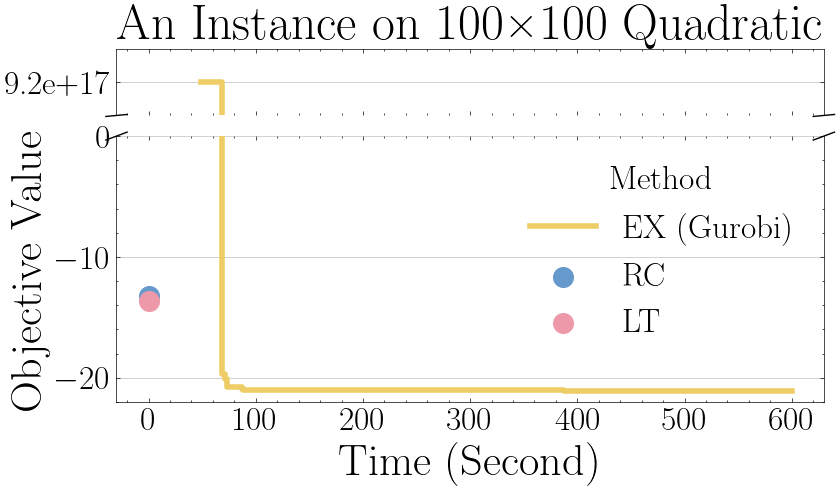

In [3]:
times = [49, 68, 71, 73, 76, 87, 88, 90, 388, 600] 
objs = [9.2105e+17, -19.6837120, -20.1223765, -20.7598846, -20.7815701, -20.9265157, -21.0435634, -21.04356, -21.1332911, -21.13329]
plotObj(times, objs)